# Predicting House Prices

Supervised Learning. Regression

Sales prices prediction using an artificial neural network in Keras.

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper

#helper.reproducible(seed=9) # Setup reproducible results from run to run using Keras
sns.set()

## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/house_prices_data.csv'
target = ['SalePrice']

df_original = pd.read_csv(data_path)
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df_original.shape, target))

rows: 1460 
columns: 81 
target: ['SalePrice']


### Show original data

In [3]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

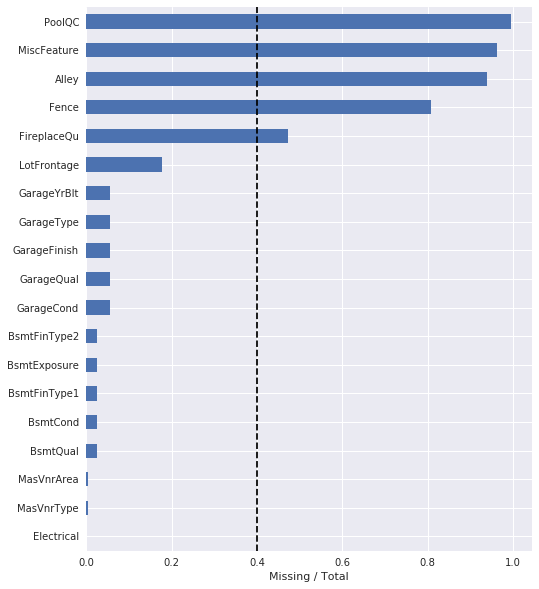

In [4]:
high_missing = helper.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform features

#### Delete irrelevant features

In [5]:
df = df_original.copy() # modified dataset

# remove non-significant and high-missing features
droplist = ['Id'] + high_missing

assert len(set(droplist).intersection(set(target)))==0, 'Targets cannot be dropped'

df.drop(droplist, axis='columns', inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [6]:
features = [field for field in df if field not in target]

df = df[features + target]

# convert dataframe values to numerical
# df = df.apply(pd.to_numeric, errors='coerce')

categorical = [feat for feat in features if df[feat].dtype == 'object']
numerical = [feat for feat in features if df[feat].dtype != 'object']

#df = helper.classify_data(df, target, numerical=numerical)

#### Remove low frequency values from categorical features

In [7]:
df.loc[:, categorical] = helper.remove_lowfreq(df.loc[:, categorical], show=False)

#### Fill missing values

In [9]:
# numerical
df.fillna(df[numerical].median(), inplace=True)  # NaN from numerical feature replaced by mean

# categorical
modes = df[categorical].mode() 
for idx, f in enumerate(df[categorical]):
    df[f].fillna(modes.iloc[0, idx], inplace=True)

### Visualize the data

(34900, 600000)

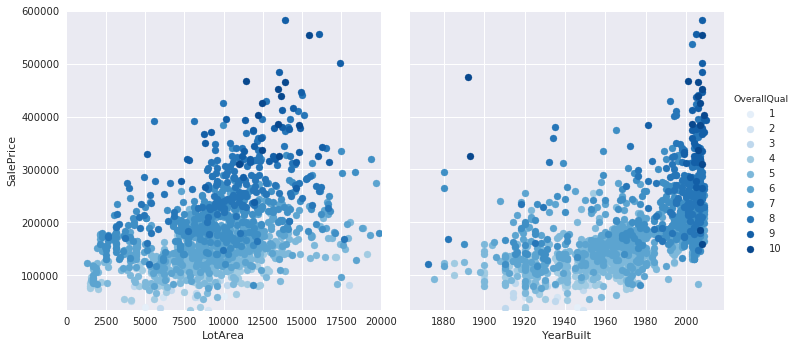

In [10]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], size=5, hue='OverallQual', palette = "Blues")
g.map(plt.scatter).add_legend()
g.axes[0,0].set_xlim(0,20000)
plt.ylim(df['SalePrice'].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

### Create dummy variables

In [11]:
dummy_fields = categorical

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(dummy_fields, axis='columns')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,1,0,0,1,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,1,0,0,1,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,1,0,0,1,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,1,0,0,1,1,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,1,0,0,1,0,0,1,0


### Scale numerical variables
The scaling factors are saved so we can go backwards when we use the network for predictions.

In [12]:
quant_features = numerical

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

scaled_target = {}
for f in target:
    mean, std = df[f].mean(), df[f].std()
    scaled_target[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std    
    
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073350,-0.220799,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.513928,0.575228,-0.288554,...,0,0,1,0,0,1,0,0,1,0
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.570555,1.171591,-0.288554,...,0,0,1,0,0,1,0,0,1,0
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984415,0.829930,0.325803,0.092875,-0.288554,...,0,0,1,0,0,1,0,0,1,0
3,0.309753,-0.447787,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.570555,-0.499103,-0.288554,...,0,0,1,0,0,1,1,0,0,0
4,0.073350,0.641752,0.375020,1.374324,-0.517023,0.951306,0.733056,1.366021,0.463410,-0.288554,...,0,0,1,0,0,1,0,0,1,0


### Tune features selection
Fast way to remove features before training the model

In [13]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'

### Split the data into training and test sets

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.2, random_state=9)

# Separate the data into features and targets (x=features, y=target)
x_train, y_train = train.drop(target, axis=1).values, train[target].values
x_test, y_test = test.drop(target, axis=1).values, test[target].values
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1068,2.437384,-1.264940,-0.656513,-0.071812,-1.415657,0.057352,-0.574741,-0.570555,0.862447,-0.288554,...,0,0,1,0,0,1,0,0,1,0
271,-0.872264,0.142380,2.864083,0.651256,1.280247,-0.571727,0.975241,-0.570555,-0.477177,6.300863,...,0,0,1,0,0,1,0,0,1,0
39,0.782560,-0.220799,-0.448523,-1.517947,-0.517023,-0.538617,-1.446605,-0.570555,-0.972685,-0.288554,...,1,0,0,0,0,1,0,0,1,0
775,1.491770,-1.718915,-0.602812,-0.071812,-0.517023,0.885087,0.636183,1.200029,0.926029,-0.288554,...,0,0,1,0,0,1,0,0,1,0
247,-0.872264,0.233175,0.079466,-0.071812,-0.517023,-0.571727,-1.495042,-0.570555,-0.972685,-0.288554,...,0,0,1,0,0,1,0,0,1,0


## Deep Neural Network
  

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 96)                18528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 18,625
Trainable params: 18,625
Non-trainable params: 0
_________________________________________________________________
Training ....
Epoch 00094: early stopping


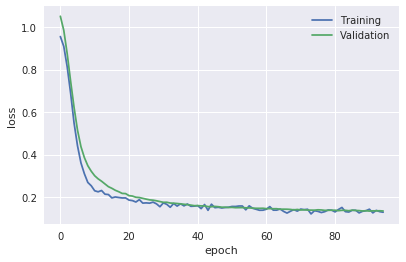


Training loss:  	0.1294
Validation loss: 	0.1354


In [15]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

nodes = x_train.shape[1]//2
weights = keras.initializers.RandomNormal(stddev=0.0001)

model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = weights))
model.add(Dropout(.4))
model.add(Dense(1, activation=None,
               kernel_initializer = weights,
               bias_initializer = weights))
model.summary()

opt = keras.optimizers.adam(lr=0.00005)
model.compile(loss='mean_squared_error', optimizer=opt)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
print('Training ....')
history = model.fit(x_train, y_train, epochs=10000, batch_size=16, verbose=0, 
                    validation_split=0.1, callbacks=callbacks)
helper.show_training(history)

### Make predictions

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("\n Test loss: {:.4f}".format(score))


 Test loss: 0.1592


In [17]:
pred = model.predict(x_test, verbose=0)
restore_pred = pred * scaled_target['SalePrice'][1] + scaled_target['SalePrice'][0]
restore_pred = restore_pred.round()

restore_y = y_test * scaled_target['SalePrice'][1] + scaled_target['SalePrice'][0]
restore_y = restore_y.round()

pred_df = pd.DataFrame({'SalePrice': np.squeeze(restore_y), 
                              'Predicted SalePrice': np.squeeze(restore_pred)})

pred_df['Prediction error (%)'] = ((pred_df['Predicted SalePrice'] - pred_df['SalePrice']) * 100 
                                   /  pred_df['SalePrice']).round(1)
pred_df.head(10)

,Predicted SalePrice,SalePrice,Prediction error (%)
0,212549.0,151400.0,40.4
1,212578.0,241500.0,-12.0
2,83383.0,82000.0,1.7
3,161273.0,162000.0,-0.4
4,143652.0,140000.0,2.6
5,214519.0,227000.0,-5.5
6,235106.0,228950.0,2.7
7,184559.0,208300.0,-11.4
8,127903.0,128500.0,-0.5
9,164532.0,165000.0,-0.3


Prediction error:
Mean: 	 0.18%
Stddev:  10.97%


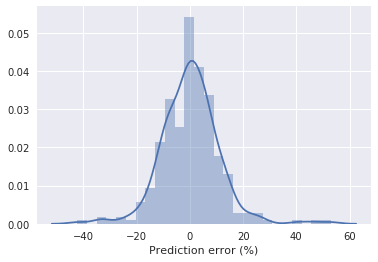

In [18]:
pred_error = pred_df['Prediction error (%)']

print("Prediction error:")
print("Mean: \t {:.2f}%".format(pred_error.mean()))
print("Stddev:  {:.2f}%".format(pred_error.std()))

sns.distplot(pred_error);

The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 11%. Thus, ~95% of the houses are predicted within a price error < 22% respect to the actual one. These results are not bad at all considering we are predicting the test houses, never used to train the model.